# [LVV-T1876] - Settling Time After a Slew

Notebook containing data analysis for the [LVV-T1876] test case.  
~The script used to run this test case can be found in [lsst-ts/ts_m1m3supporttesting/M13T012.py].~


[LVV-T1876]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/2237
[lsst-ts/ts_m1m3supporttesting/M13T012.py]: https://github.com/lsst-ts/ts_m1m3supporttesting/blob/develop/M13T012.py


see [LVV-T2732_analysis_mt_encoder_slew_jitter.ipynb] for jitter  ideas?

[LVV-T2732_analysis_mt_encoder_slew_jitter.ipynb]: https://github.com/lsst-sitcom/notebooks_vandv/blob/develop/notebooks/tel_and_site/subsys_req_ver/tma/LVV-T2732_analysis_mt_encoder_slew_jitter.ipynb

Some pending items(June 8th 2023) --> add as issues:
1. Get some RMS requirements 
2. Tweak parameters for stationarity, for a robust measurement


### Prepare Notebook

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimezoneInfo
from statsmodels.tsa.stattools import adfuller

from lsst.sitcom import vandv
from lsst.ts.idl.enums import MTM1M3
from lsst_efd_client import EfdClient

import identify_slews

In [3]:
client = EfdClient('usdf_efd')

### Define functions

In [4]:
def determineSettleTime(df_ims, #input data frame
                        T0_tag = '2023-06-01T06:00:0Z', #time for slew stop
                        imsColumn = 'xPosition', #IMS column
                        rmsReq = 1e-2, #requirement in appropriate units
                        delta_t = 3): #time for settling, in seconds
    #T0 and T1 defines the window for requirement to be met
    T0 = pd.to_datetime(T0_tag)
    T1 = T0 + pd.to_timedelta(delta_t,unit='s')
    # delta_window is the time window for plot and reference for mean, before and after T0
    delta_window = [pd.Timedelta(5, "seconds"),pd.Timedelta(15, "seconds")] 

    if 'Position' in imsColumn:
        units = 'mm'
    else:
        units = 'deg'

    #zoom around the T0 of interest
    TZoom = [T0-delta_window[0],  
            T0+delta_window[1]] 
    #idx indicates the index of data frame corresponding to certain times
    idx = [df_ims.index[df_ims.index.get_indexer([pd.to_datetime(T0)], method='nearest')],
          df_ims.index[df_ims.index.get_indexer([pd.to_datetime(T1)], method='nearest')],
          df_ims.index[df_ims.index.get_indexer([pd.to_datetime(TZoom[1])], method='nearest')]]    
    #pos is the array of values in delta_window with respect to value at T0 
    pos = (df_ims[imsColumn][TZoom[0]:TZoom[1]] - df_ims[imsColumn][idx[0][0]])#.rolling(100).mean()
    #pos_ref is the array of values in delta_t wrt reference value, taking the end of the window for that
    # TBC if this is a valid approach
    pos_ref = (df_ims[imsColumn][idx[0][0]:idx[1][0]] - df_ims[imsColumn][idx[2][0]])
    rms = np.std(pos_ref) 

    title = imsColumn
    label = imsColumn + '(' + units +') wrt T0 (slew stop)'

    fig = plt.figure()
    plt.plot(pos[TZoom[0]:TZoom[1]],color='red', lw="0.5", label=label)
    #plt.axvline(pd.to_datetime(T0), lw="2", c="k", linestyle='dashed')
    plt.axvline(T1, lw="0.5", c="k")
    #plt.axhline(-req)
    #plt.axhline(req)
    plt.xlabel("Time [UTC]")
    plt.ylabel(label)
    #plt.title(label)
    plt.text(0.55, 0.70, 'RMS =' + ' {:.2e} '.format(rms) + units + 
             ' in 3s window, wrt end of plot', 
             transform=fig.transFigure)
    fig.autofmt_xdate()
    fig.tight_layout()

    #recomputing RMS for the whole range since T0
    rms = (df_ims[imsColumn][T0:TZoom[1]] - df_ims[imsColumn][idx[2][0]]).rolling(20).std()
    plt.plot(rms, label='RMS wrt value at the end of plot, from T0')
    plt.axvspan(T0, T1, alpha=0.5, color='green', label='3s tolerance window')
    plt.legend(loc="upper right")

    ## compute time for settling
    fig = plt.figure()    
    rms = rms.dropna() # remove NaNs created by the rolling function
    lapse = 100 # to be adjusted
    pvalue = 0.05 ## lower, less tolerant to finding stationarity, to be adjusted
    for i in range(0,len(rms)-lapse):
        adf = adfuller(rms[i:i+lapse], autolag='AIC')
        if adf[1] < pvalue: # is non-stationary if null hypothesis is true (large p-value)
            print(i, i+lapse, adf[1], pvalue)
            print(rms.index[i], rms.index[i+lapse])
            break

    plt.plot(rms)
    plt.xlabel("Time [UTC]")
    plt.ylabel('RMS wrt value at the end of plot (mm)')    
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.text(0.35, 0.70, 'Settling time (ADF test) =' + rms.index[i+lapse].strftime('%H:%M:%S.%f'), transform=fig.transFigure)        

    print('T0:',pd.to_datetime(T0))
    print('T_settle:',rms.index[i+lapse])
    print(rms.index[i+lapse]-pd.to_datetime(T0))
    
    return rms.index[i+lapse]

In [29]:
def compareIMSMount(df_ims,
                   df_mtmount_ele,
                   df_mtmount_azi,
                   slew_stop = '2023-06-01 06:53:37.326',
                   lo_delta_t = 5,
                   hi_delta_t = 30,
                   correct_tai = True): #in seconds
    
    tai_delta = 0
    if correct_tai:
        tai_delta = 37
    
    fig,axs = plt.subplots(5,1, dpi=125, figsize=(6,8))
    t_start_plot = pd.to_datetime(slew_stop) \
        + pd.to_timedelta(tai_delta,unit='s') - pd.to_timedelta(lo_delta_t,unit='s') ##correcting by hand for TAI, is this correct?
    t_end_plot = pd.to_datetime(slew_stop) \
        + pd.to_timedelta(tai_delta,unit='s') + pd.to_timedelta(hi_delta_t,unit='s')

    ax = axs[0]
    actpos_ele = df_mtmount_ele['actualPosition'][t_start_plot:t_end_plot]
    ax.plot(actpos_ele,color='red', lw="0.5")
    ax.axvline(pd.to_datetime(slew_stop)+ pd.to_timedelta(37,unit='s'), lw="0.5", c="k")
    ax.set_ylabel("Elevation Position\n[deg]")

    ax = axs[1]
    actpos_azi = df_mtmount_azi['actualPosition'][t_start_plot:t_end_plot]
    ax.plot(actpos_azi,color='red', lw="0.5")
    ax.set_ylabel("Azimuth Position\n[deg]")

    t_start_plot = pd.to_datetime(slew_stop) - pd.to_timedelta(lo_delta_t,unit='s') 
    t_end_plot = pd.to_datetime(slew_stop) + pd.to_timedelta(hi_delta_t,unit='s')
    
    plotstring = ['xPosition','yPosition','zPosition']
    plotrange = np.arange(len(plotstring))    
    for i in plotrange:
        ax = axs[i+2]
        pos = df_ims[plotstring[i]][t_start_plot:t_end_plot]
        ax.plot(pos,color='red', lw="0.5")
        ax.set_ylabel(plotstring[i] + ' in mm')
    ax.set_xlabel('UTC')
    fig.autofmt_xdate()

### Query Data

In [6]:
all_columns = ["xPosition", "xRotation", "yPosition", "yRotation", "zPosition", "zRotation"]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]
print(pos_columns, rot_columns)

['xPosition', 'yPosition', 'zPosition'] ['xRotation', 'yRotation', 'zRotation']


In [7]:
#define the date
t_start = Time('2023-06-01 06:00:0Z', scale='utc')
t_end = Time('2023-06-01 10:00:0Z', scale='utc') 

### Load data

In [28]:
df_ims = await client.select_time_series(
    "lsst.sal.MTM1M3.imsData", 
    "*", 
    Time(t_start, format="isot", scale="utc"),
    Time(t_end, format="isot", scale="utc"), 
)

df_ims = df_ims.set_index("private_sndStamp")
df_ims.index = pd.to_datetime(df_ims.index, unit="s")
df_ims = df_ims[all_columns]

df_ims[pos_columns] = df_ims[pos_columns] * 1e3 #to mm
df_ims[rot_columns] = np.rad2deg(df_ims[rot_columns]) #to degrees

ValueError: Timestamps must be in UTC.

In [9]:
df_mtmount_ele = await client.select_time_series(
    "lsst.sal.MTMount.elevation",
    ["*"],  
    Time(t_start, format="isot", scale="utc"),
    Time(t_end, format="isot", scale="utc"), 
)
df_mtmount_ele = df_mtmount_ele.set_index("private_sndStamp")
df_mtmount_ele.index = pd.to_datetime(df_mtmount_ele.index, unit="s")

df_mtmount_azi = await client.select_time_series(
    "lsst.sal.MTMount.azimuth",
    ["*"],  
    Time(t_start, format="isot", scale="utc"),
    Time(t_end, format="isot", scale="utc"), 
)
df_mtmount_azi = df_mtmount_azi.set_index("private_sndStamp")
df_mtmount_azi.index = pd.to_datetime(df_mtmount_azi.index, unit="s")


### Get slew stops

In [ ]:
##identify a slew stop
starts,stops, maxv=identify_slews.get_slews_edge_detection(mtmount["timestamp"],mtmount["actualVelocity"])
starts,stops = identify_slews.get_slew_pairs(starts,stops)

In [10]:
#from lsst.sitcom import vandv
#start = Time("2023-06-01T06:00:55", scale='utc')
#end = Time("2023-06-01T09:09:58", scale='utc')
#az = await client.select_time_series('lsst.sal.MTMount.azimuth', \
#                                            ['actualPosition','actualVelocity', 'timestamp'],  start, end)
#el = await client.select_time_series('lsst.sal.MTMount.elevation', \
#                                        ['actualPosition','actualVelocity', 'timestamp'],  start, end)
#el_starts,el_stops = vandv.mount.get_slew_from_mtmount(el)

#print(Time(el_stops, format="unix").iso)   

stops = ['2023-06-01 06:45:39.978','2023-06-01 06:53:37.326',
         '2023-06-01 07:22:22.723','2023-06-01 07:36:40.422',
         '2023-06-01 07:50:58.814','2023-06-01 08:05:17.119',
         '2023-06-01 08:19:03.799','2023-06-01 08:34:19.955',
         '2023-06-01 08:47:56.442','2023-06-01 09:01:33.275']

### Look at data

In [11]:
print(stops[0])
print(stops[1])

2023-06-01 06:45:39.978
2023-06-01 06:53:37.326


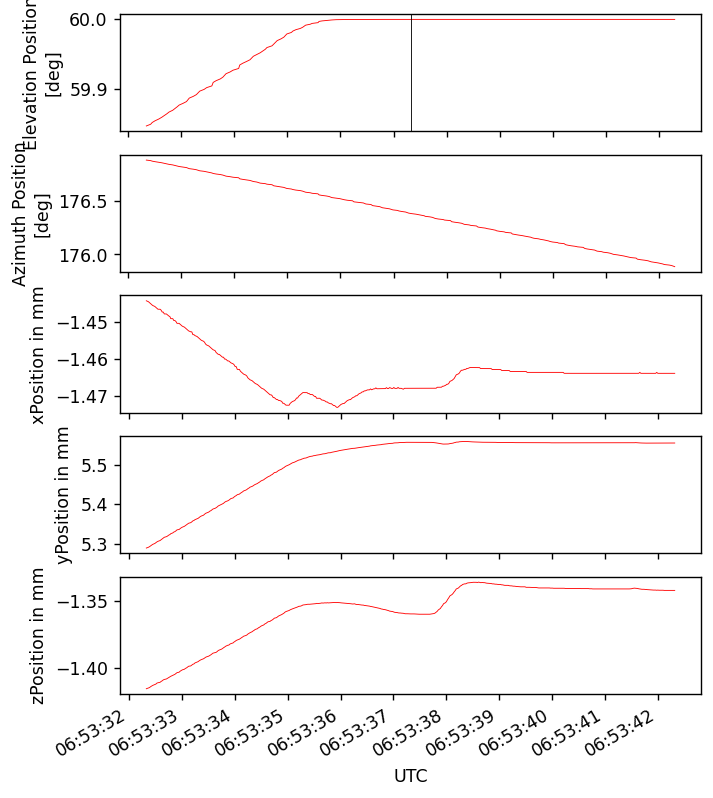

In [27]:
compareIMSMount(df_ims,df_mtmount_ele,df_mtmount_azi,stops[1],5,5,correct_tai=True)

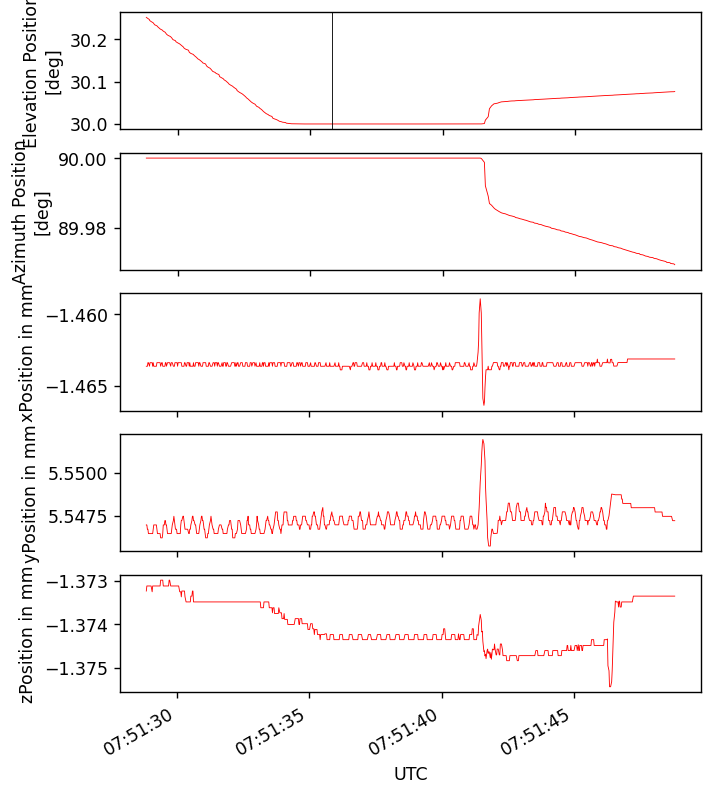

In [26]:
compareIMSMount(df_ims,df_mtmount_ele,df_mtmount_azi,stops[4],-30,50,correct_tai=False)

## t_start_plot = '2023-06-01 06:53:00'
t_end_plot = '2023-06-01 06:55:00'
pos = df_ims['xPosition'][t_start_plot:t_end_plot]#.rolling(100).mean()
fig = plt.figure()
plt.plot(pos,color='red', lw="0.5")
plt.ylabel('xPosition in mm')
plt.xlabel('UTC')
fig.autofmt_xdate()
fig.tight_layout()
pos = df_ims['yPosition'][t_start_plot:t_end_plot]#.rolling(100).mean()
fig = plt.figure()
plt.plot(pos,color='red', lw="0.5")
fig.autofmt_xdate()
fig.tight_layout()
pos = df_ims['zPosition'][t_start_plot:t_end_plot]#.rolling(100).mean()
fig = plt.figure()
plt.plot(pos,color='red', lw="0.5")
fig.autofmt_xdate()
fig.tight_layout()
pos = df_ims['xRotation'][t_start_plot:t_end_plot]#.rolling(100).mean()
fig = plt.figure()
plt.plot(pos,color='red', lw="0.5")
fig.autofmt_xdate()
fig.tight_layout()
pos = df_ims['yRotation'][t_start_plot:t_end_plot]#.rolling(100).mean()
fig = plt.figure()
plt.plot(pos,color='red', lw="0.5")
fig.autofmt_xdate()
fig.tight_layout()
pos = df_ims['zRotation'][t_start_plot:t_end_plot]#.rolling(100).mean()
fig = plt.figure()
plt.plot(pos,color='red', lw="0.5")
fig.autofmt_xdate()
fig.tight_layout()

### Run test

In [28]:
delta_t = 3 ## seconds
T0_tag = stops[9]#'2023-06-01T06:53:37.326'
req = 1e-2 

Timestamp('2023-06-01 06:53:40.448126976')

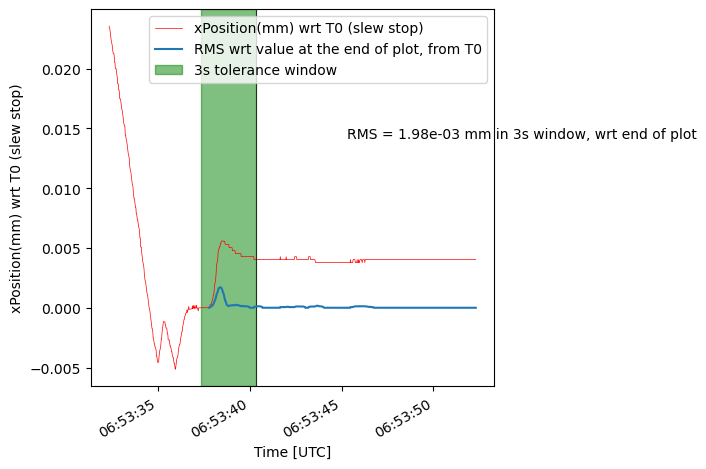

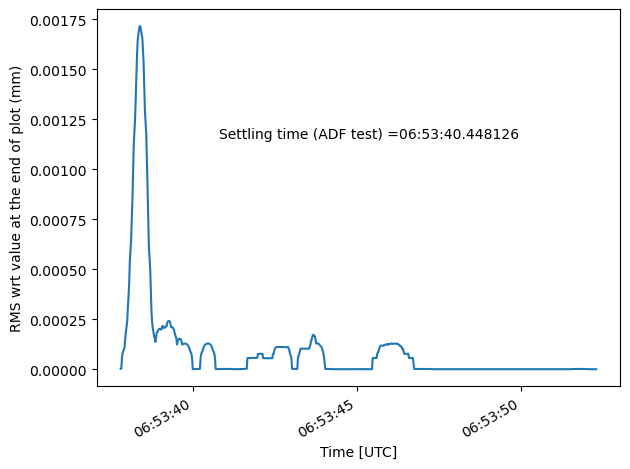

In [30]:
%%capture --no-display 
T0_tag = stops[1]
determineSettleTime(df_ims = df_ims, T0_tag = T0_tag, 
                    imsColumn = 'xPosition', 
                    rmsReq = req, 
                    delta_t = delta_t)
#determineSettleTime(df_ims = df_ims, T0_tag = T0_tag, 
#                    imsColumn = 'yPosition', 
#                    rmsReq = req, 
#                    delta_t = delta_t)
#determineSettleTime(df_ims = df_ims, T0_tag = T0_tag, 
#                    imsColumn = 'zPosition', 
#                    rmsReq = req, 
#                    delta_t = delta_t)
#determineSettleTime(df_ims = df_ims, T0_tag = T0_tag, 
#                   imsColumn = 'xRotation', 
#                   rmsReq = req, 
#                   delta_t = delta_t)
#determineSettleTime(df_ims = df_ims, T0_tag = T0_tag, 
#                   imsColumn = 'yRotation', 
#                   rmsReq = req, 
#                   delta_t = delta_t)
#determineSettleTime(df_ims = df_ims, T0_tag = T0_tag, 
#                   imsColumn = 'zRotation', 
#                   rmsReq = req, 
#                   delta_t = delta_t)

In [ ]:
print(rms[4:])
print(rms.index[4])

In [ ]:
#### Check a the contents of the pos array
pd.set_option('display.max_rows', 500)
print(pos_check)
print(np.std(pos_check))

In [ ]:
### Overplotting all columns
fig = plt.figure()

xpos = (df_ims['xPosition'] - df_ims['xPosition'][0]).rolling(100).mean()
ypos = (df_ims['yPosition'] - df_ims['yPosition'][0]).rolling(100).mean()
zpos = (df_ims['zPosition'] - df_ims['zPosition'][0]).rolling(100).mean()
xrot = (df_ims['xRotation'] - df_ims['xRotation'][0]).rolling(100).mean()
yrot = (df_ims['yRotation'] - df_ims['yRotation'][0]).rolling(100).mean()
zrot = (df_ims['zRotation'] - df_ims['zRotation'][0]).rolling(100).mean()
plt.plot(xpos,color='red', lw="0.5", label='xPosition (mm) wrt T0')
plt.plot(ypos,color='blue', lw="0.5", label='yPosition (mm) wrt T0')
plt.plot(zpos,color='green', lw="0.5", label='zPosition (mm) wrt T0')
#plt.plot(xrot,color='red', lw="0.5", linestyle='dashed', label='xRotation (degrees) wrt T0')
#plt.plot(yrot,color='blue', lw="0.5", linestyle='dashed', label='yRotation (degrees) wrt T0')
#plt.plot(zrot,color='green', lw="0.5", linestyle='dashed', label='zRotation (degrees) wrt T0')
plt.legend(ncols=2, loc="upper right", bbox_to_anchor=(0.80, 1.3))
plt.xlabel("Time [UTC]")
fig.autofmt_xdate()
fig.tight_layout()

In [ ]:
df_ims = await client.select_time_series(
    "lsst.sal.MTM1M3.imsData", 
    "*", 
    Time(t_start, format="isot", scale="utc"),
    Time(t_end, format="isot", scale="utc"), 
)
print(df_ims)